In [1]:
from selenium import webdriver

import time
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
import urllib.request as req

import requests
import os
import glob
import datetime
import re

In [2]:
address = "autumn.vb.cats1014@docomo.ne.jp"
password = "1378fk1014"

In [3]:
options = webdriver.ChromeOptions()
headers = {"User-Agent": "Mozilla/5.0"}
prefs = {"download.default_directory" : "C:\\Users\\sasno\\Desktop\\Mypandas\\vleague"}
options.add_experimental_option("prefs", prefs)
options.add_argument("--headless")

In [4]:
# GoogleChromeを起動
browser = webdriver.Chrome(executable_path='C:\\Users\\sasno\\anaconda3\\lib\\site-packages\\chromedriver_binary\\chromedriver.exe', options=options)
browser.implicitly_wait(3)

In [13]:
browser.close()

In [5]:
# ログインするサイトへアクセス
url_login = "https://vleague.tv/signin"
browser.get(url_login)
time.sleep(3)
print("ログインページにアクセスしました")

ログインページにアクセスしました


In [6]:
# テキストボックス入力
element = browser.find_element_by_id('account-mail')
element.clear()
element.send_keys(address)
element = browser.find_element_by_id('account-pw')
element.clear()
element.send_keys(password)
print("フォームを送信")
# 入力したデータをクリック
browser_from = browser.find_element_by_class_name('btn_submit')
time.sleep(1)
browser_from.click()
print("情報を入力してログインボタンを押しました")
# ログインするサイトへアクセス
time.sleep(1)
url_login = 'https://vleague.tv/match'
browser.get(url_login)
time.sleep(3)
print("ログインページにアクセスしました")

フォームを送信
情報を入力してログインボタンを押しました
ログインページにアクセスしました


In [8]:
os.chdir('C:\\Users\\sasno\\Desktop\\MyPandas\\vleague')
division = 'v1_m'
s_round = '2020-21_regular'
# game_set = 1
os.chdir('{}'.format(division))
print(os.getcwd())
# Scheduleからライブスコアを取得
# for文で回す
# 試合
# 177
def remove_csv(csvs):
    for csv in csvs:
        if os.path.exists(csv):
            os.remove(csv)
    print('既存のcsvを削除')

for game_num in range(1, 2):
#     try:
        browser.get(url_login)
        daily = browser.find_element_by_xpath('//*[@id="schedule"]/div/div[3]/div[{}]/div[2]/p[1]'.format(game_num)).text
        daily = daily.replace('.', '-')[:10]
        element = browser.find_element_by_xpath('//*[@id="schedule"]/div/div[3]/div[{}]/p/a'.format(game_num))
        element.click()
        time.sleep(1)
        element = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[1]/ul/li[2]')
        element.click()
        time.sleep(1)
        team = browser.find_elements_by_class_name('team_name')
        h_team = team[0].text
        a_team = team[1].text
        print(daily, h_team, a_team)
        game_sets = browser.find_element_by_class_name('history_set').text
        for game_set in range(1, game_sets.count('\n')+2):
            browser.execute_script("window.scrollTo(0, 0)")
            browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            element = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/ul/li[{}]'.format(game_set))
            element.click()
            time.sleep(1)
            historys = browser.find_elements_by_class_name('history_item')
            # print(len(historys))
            log_len = len(historys)
            text = ""

            log_lists = []
            home_p = 0
            away_p = 0
#             print(log_len)
            try:
                for i in range(1, log_len+1):
    #                     //*[@id="livescore"]/div[3]/div[2]/div/div[1]/div[1]
                    home_history = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/div/div[{}]/div[1]'.format(str(i))).text
                #     print(home_history)
                    home_point = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/div/div[{}]/div[2]'.format(str(i))).text
                    if home_point == '':
                        home_point = home_p
                    else:
                        home_p = int(home_point)
                    away_history = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/div/div[{}]/div[5]'.format(str(i))).text
                    away_point = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/div/div[{}]/div[4]'.format(str(i))).text
                    if away_point == '':
                        away_point = away_p
                    else:
                        away_p = int(away_point)
                #     print(home_point, away_point)
                    log_list = [home_p, away_p, home_history, away_history]
                #     print(log_list)
                    log_lists.append(log_list)
                    log_df = pd.DataFrame(data=log_lists)
            
    #             print(log_lists[-1])
                home_log = log_df[2].str.split(expand=True)
                home_log = home_log.mask(home_log.loc[:, 2].isnull()==True, home_log.shift(axis=1))
                # print(len(home_log.columns))
                if len(home_log.columns) == 3:
                    home_log[["交代番号", "交代選手"]] = None
                home_log.columns = ["状況", "番号", "選手", "交代番号", "交代選手"]
                # home_log
                away_log = log_df.loc[:, 3].str.split(expand=True)
                away_log = away_log.mask(away_log.loc[:, 2].isnull()==True, away_log.shift(axis=1))
                # print(len(away_log.columns))
                if len(away_log.columns) == 3:
                    away_log[["相手交代番号", "相手交代選手"]] = None
                away_log.columns = ["相手状況", "相手番号", "相手選手", "相手交代番号", "相手交代選手"]
                # away_log
                point = log_df[[0,1]]
                point.columns = ["得点", "失点"]
                # SettingWithCopyWarning: 後から修正
                point['+/-'] = point["得点"] - point["失点"]
                f = lambda x: 'Lead' if x > 0 else ('Tie' if x == 0 else 'Behind') 
                point['L-B'] = point['+/-'].map(f)
                # point
                away_point = point.reindex(["失点", "得点", '+/-', 'L-B'], axis=1)
                away_point['+/-'] = away_point['+/-'].map(lambda x: -x)
                away_point['L-B'] = away_point['+/-'].map(f)
                away_point.columns = ["得点", "失点", '+/-', 'L-B']
                # away_point
                home_game_log = pd.concat([point, home_log, away_log], axis=1)
                away_game_log = pd.concat([away_point, away_log, home_log], axis=1)
                away_game_log.columns = home_game_log.columns
            except:
                print('error_1')
                pass

            home_csv = '{}/{}/{}-livescore-{}set.csv'.format(h_team, s_round, daily, game_set)
            away_csv = '{}/{}/{}-livescore-{}set.csv'.format(a_team, s_round, daily, game_set)
            home_csv_2 = 'all/{}/{}-livescore-{}vs{}-{}set.csv'.format(s_round, daily, h_team, a_team, game_set)
            away_csv_2 = 'all/{}/{}-livescore-{}vs{}-{}set.csv'.format(s_round, daily, a_team, h_team, game_set)
#             remove_csv([home_csv, away_csv, home_csv_2, away_csv_2])
                        
            if(len(home_game_log) > 10):
                home_game_log.to_csv(home_csv, index=False)
                away_game_log.to_csv(away_csv, index=False)
                home_game_log.to_csv(home_csv_2, index=False)
                away_game_log.to_csv(away_csv_2, index=False)
                print('{}セット目csv作成成功'.format(game_set))
            else:
                print('データ無し')
            time.sleep(1)
            
#     except:
#         print('error_2')
#         time.sleep(1)
#         pass

C:\Users\sasno\Desktop\MyPandas\vleague\v1_m
2020-10-17 堺ブレイザーズ VC長野トライデンツ


C:\Users\sasno\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1セット目csv作成成功


C:\Users\sasno\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2セット目csv作成成功


C:\Users\sasno\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3セット目csv作成成功


C:\Users\sasno\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4セット目csv作成成功


In [200]:
home_csv = '{}/{}/{}-livescore-{}set.csv'.format(h_team, s_round, daily, game_set)
away_csv = '{}/{}/{}-livescore-{}set.csv'.format(a_team, s_round, daily, game_set)
os.path.exists(away_csv)

True

In [8]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [ ]:
os.chdir('C:\\Users\\sasno\\Desktop\\MyPandas\\vleague')
division = 'v1_w'
s_round = '2020-21_regular'
# game_set = 1
os.chdir('{}'.format(division))
print(os.getcwd())
# Scheduleからライブスコアを取得
# for文で回す
# 試合
def remove_csv(csvs):
    judge = False
    for csv in csvs:
        if os.path.exists(csv):
            os.remove(csv)
            judge = True
    if judge:
        print('既存のcsvを削除')

def click(path):
    element = browser.find_element_by_xpath(path)
    browser.implicitly_wait(3)
    element.click()
    time.sleep(1)
        
text = ''

def create_csv():
    browser.get(url_login)
    time.sleep(1)
    #         v1_w
    element = browser.find_element_by_xpath('//*[@id="schedule"]/div/div[1]/ul/li[4]')
    browser.implicitly_wait(3)
    element.click()
    time.sleep(1)
    element.click()

    daily = browser.find_element_by_xpath('//*[@id="schedule"]/div/div[3]/div[{}]/div[2]/p[1]'.format(game_num)).text
    daily = daily.replace('.', '-')[:10]
    click('//*[@id="schedule"]/div/div[3]/div[{}]/p/a'.format(game_num))
    click('//*[@id="livescore"]/div[3]/div[1]/ul/li[2]')
    team = browser.find_elements_by_class_name('team_name')
    h_team = team[0].text
    a_team = team[1].text
    print(game_num, daily, h_team, a_team)
    game_sets = browser.find_element_by_class_name('history_set').text

    for game_set in range(1, game_sets.count('\n')+2):
#         for game_set in range(2, 3):
        count = 0
        home_game_log = pd.DataFrame()
        while len(home_game_log) < 10 or count < 3:

            browser.execute_script("window.scrollTo(0, 0)")
            browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            browser.implicitly_wait(3)
            element = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/ul/li[{}]'.format(game_set))
            browser.implicitly_wait(3)
            element.click()
#             print(game_set)
            time.sleep(3)
            element.click()
            historys = browser.find_elements_by_class_name('history_item')
            # print(len(historys))
            log_len = len(historys)
            text = ""

            log_lists = []
            home_p = 0
            away_p = 0
#             print(log_len)
            try:
                count += 1
                log_df = pd.DataFrame()
                home_game_log = pd.DataFrame()
                away_game_log = pd.DataFrame()
                for i in range(1, log_len+1):
    #                     //*[@id="livescore"]/div[3]/div[2]/div/div[1]/div[1]
                    home_history = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/div/div[{}]/div[1]'.format(str(i))).text
                #     print(home_history)
                    home_point = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/div/div[{}]/div[2]'.format(str(i))).text
                    if home_point == '':
                        home_point = home_p
                    else:
                        home_p = int(home_point)
                    away_history = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/div/div[{}]/div[5]'.format(str(i))).text
                    away_point = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/div/div[{}]/div[4]'.format(str(i))).text
                    if away_point == '':
                        away_point = away_p
                    else:
                        away_p = int(away_point)
                #     print(home_point, away_point)
                    log_list = [home_p, away_p, home_history, away_history]
                #     print(log_list)
                    log_lists.append(log_list)
                log_df = pd.DataFrame(data=log_lists)

#             print(log_lists[-1])
                home_log = log_df[2].str.split(expand=True)
                home_log = home_log.mask(home_log.loc[:, 2].isnull()==True, home_log.shift(axis=1))
                # print(len(home_log.columns))
                if len(home_log.columns) == 3:
                    home_log[["交代番号", "交代選手"]] = None
                home_log.columns = ["状況", "番号", "選手", "交代番号", "交代選手"]
                # home_log
                away_log = log_df.loc[:, 3].str.split(expand=True)
                away_log = away_log.mask(away_log.loc[:, 2].isnull()==True, away_log.shift(axis=1))
                # print(len(away_log.columns))
                if len(away_log.columns) == 3:
                    away_log[["相手交代番号", "相手交代選手"]] = None
                away_log.columns = ["相手状況", "相手番号", "相手選手", "相手交代番号", "相手交代選手"]
                # away_log
                point = log_df[[0,1]]
                point.columns = ["得点", "失点"]
                # SettingWithCopyWarning: 後から修正
                point['+/-'] = point["得点"] - point["失点"]
                f = lambda x: 'Lead' if x > 0 else ('Tie' if x == 0 else 'Behind') 
                point['L-B'] = point['+/-'].map(f)
                # point
                away_point = point.reindex(["失点", "得点", '+/-', 'L-B'], axis=1)
                away_point['+/-'] = away_point['+/-'].map(lambda x: -x)
                away_point['L-B'] = away_point['+/-'].map(f)
                away_point.columns = ["得点", "失点", '+/-', 'L-B']
                # away_point
                home_game_log = pd.concat([point, home_log, away_log], axis=1)
                away_game_log = pd.concat([away_point, away_log, home_log], axis=1)
                away_game_log.columns = home_game_log.columns
            except:
                count += 1
                print('error_1')
                pass
            
        if count >= 3:
            text += '{}-{}set\n'.format(game_num, game_set)

        home_csv = '{}/{}/{}-livescore-{}set.csv'.format(h_team, s_round, daily, game_set)
        away_csv = '{}/{}/{}-livescore-{}set.csv'.format(a_team, s_round, daily, game_set)
        home_csv_2 = 'all/{}/{}-livescore-{}vs{}-{}set.csv'.format(s_round, daily, h_team, a_team, game_set)
        away_csv_2 = 'all/{}/{}-livescore-{}vs{}-{}set.csv'.format(s_round, daily, a_team, h_team, game_set)
#             remove_csv([home_csv, away_csv, home_csv_2, away_csv_2])

        if(len(home_game_log) > 10):
            home_game_log.to_csv(home_csv, index=False)
            away_game_log.to_csv(away_csv, index=False)
            home_game_log.to_csv(home_csv_2, index=False)
            away_game_log.to_csv(away_csv_2, index=False)
            print('{}セット目csv作成成功'.format(game_set))
        else:
            print('データ無し')
        time.sleep(1)

# 3/6 142~ 
# //*[@id="schedule"]/div/div[3]/div[146]/p/a
for game_num in range(144, 147):
    try:
        create_csv()
    except:
        print('error_2 and retry')
        text += '{}\n'.format(game_num)
        time.sleep(1)
        create_csv()
        pass
print(text)

In [ ]:
h_home = browser.find_elements_by_class_name('team_name')

In [321]:
game_sets = browser.find_element_by_class_name('history_set').text
game_sets.count('\n')

3

In [91]:
# Scheduleからライブスコアを取得
# for文で回す
browser.get(url_login)
daily = browser.find_element_by_xpath('//*[@id="schedule"]/div/div[3]/div[1]/div[2]/p[1]').text
daily = daily.replace('.', '-')[:10]
print(daily)
element = browser.find_element_by_xpath('//*[@id="schedule"]/div/div[3]/div[2]/p/a')
element.click()
time.sleep(1)
element = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[1]/ul/li[2]')
element.click()
time.sleep(1)
# セットをクリック
browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
# 1セット目
element = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/ul/li[1]')
element.click()

2020-10-17


In [29]:
daily = daily.replace('.', '-')[:10]
daily

'2020-10-17'

In [22]:
# for文で回す
team = browser.find_elements_by_class_name('team_name')
h_team = team[0].text
a_team = team[1].text
historys = browser.find_elements_by_class_name('history_item')
# print(len(historys))
log_len = len(historys)
text = ""

log_lists = []
home_p = 0
away_p = 0
for i in range(1, log_len+1):
    home_history = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/div/div[{}]/div[1]'.format(str(i))).text
#     print(home_history)
    home_point = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/div/div[{}]/div[2]'.format(str(i))).text
    if home_point == '':
        home_point = home_p
    else:
        home_p = int(home_point)
    away_history = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/div/div[{}]/div[5]'.format(str(i))).text
    away_point = browser.find_element_by_xpath('//*[@id="livescore"]/div[3]/div[2]/div/div[{}]/div[4]'.format(str(i))).text
    if away_point == '':
        away_point = away_p
    else:
        away_p = int(away_point)
#     print(home_point, away_point)
    log_list = [home_p, away_p, home_history, away_history]
#     print(log_list)
    log_lists.append(log_list)
    log_df = pd.DataFrame(data=log_lists)
print(log_lists[-1])
log_df

[25, 20, '得点', '']


,0,1,2,3
0,0,0,,
1,0,0,,サーブ 8 河東
2,0,0,レシーブ成功(良) 4 高野,
3,0,0,21 竹元,
4,0,0,,7 戸嵜
...,...,...,...,...
205,24,20,,得点
206,24,20,メンバー交代: IN:7 出耒田 OUT:12 小池,
207,24,20,,メンバー交代: IN:21 高澤 OUT:4 中村
208,24,20,,サーブミス 21 高澤


In [7]:
# 出来ない
def log_processing(log_df):
    home_log = log_df.loc[:, 2].str.split(expand=True)
    home_log = home_log.mask(home_log.loc[:, 2].isnull()==True, home_log.shift(axis=1))
    home_log.columns = ["状況", "番号", "選手", "交代番号", "交代選手"]
    # home_log
    away_log = log_df.loc[:, 3].str.split(expand=True)
    away_log = away_log.mask(away_log.loc[:, 2].isnull()==True, away_log.shift(axis=1))
    away_log.columns = ["相手状況", "相手番号", "相手選手", "相手交代番号", "相手交代選手"]
    # away_log
    point = log_df[[0,1]]
    point.columns = ["得点", "失点"]
    # point
    game_log = pd.concat([point, home_log, away_log], axis=1)
    return game_log

In [31]:
home_log = log_df[2].str.split(expand=True)
home_log = home_log.mask(home_log.loc[:, 2].isnull()==True, home_log.shift(axis=1))
# print(len(home_log.columns))
if len(home_log.columns) == 3:
    home_log[["交代番号", "交代選手"]] = None
home_log.columns = ["状況", "番号", "選手", "交代番号", "交代選手"]
# home_log
away_log = log_df.loc[:, 3].str.split(expand=True)
away_log = away_log.mask(away_log.loc[:, 2].isnull()==True, away_log.shift(axis=1))
# print(len(away_log.columns))
if len(away_log.columns) == 3:
    away_log[["相手交代番号", "相手交代選手"]] = None
away_log.columns = ["相手状況", "相手番号", "相手選手", "相手交代番号", "相手交代選手"]
# away_log
point = log_df[[0,1]]
point.columns = ["得点", "失点"]
# SettingWithCopyWarning: 後から修正
point['+/-'] = point["得点"] - point["失点"]
f = lambda x: 'Lead' if x > 0 else ('Tie' if x == 0 else 'Behind') 
point['L-B'] = point['+/-'].map(f)
# point
away_point = point.reindex(["失点", "得点", '+/-', 'L-B'], axis=1)
away_point['+/-'] = away_point['+/-'].map(lambda x: -x)
away_point['L-B'] = away_point['+/-'].map(f)
away_point.columns = ["得点", "失点", '+/-', 'L-B']
# away_point
home_game_log = pd.concat([point, home_log, away_log], axis=1)
away_game_log = pd.concat([away_point, away_log, home_log], axis=1)
away_game_log.columns = home_game_log.columns
# home_game_log.to_csv('{}.csv'.format(h_team), index=False)
# away_game_log.to_csv('{}.csv'.format(a_team), index=False)
# home_game_log
away_game_log

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手
0,0,0,0,Tie,NaN,None,None,None,None,NaN,None,None,None,None
1,0,0,0,Tie,サーブ,8,河東,None,None,NaN,None,None,None,None
2,0,0,0,Tie,NaN,None,None,None,None,レシーブ成功(良),4,高野,None,None
3,0,0,0,Tie,NaN,None,None,None,None,NaN,21,竹元,None,None
4,0,0,0,Tie,NaN,7,戸嵜,None,None,NaN,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,20,24,-4,Behind,NaN,得点,None,None,None,NaN,None,None,None,None
206,20,24,-4,Behind,NaN,None,None,None,None,メンバー交代:,IN:7,出耒田,OUT:12,小池
207,20,24,-4,Behind,メンバー交代:,IN:21,高澤,OUT:4,中村,NaN,None,None,None,None
208,20,24,-4,Behind,サーブミス,21,高澤,None,None,NaN,None,None,None,None


In [169]:
home_game_log

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
0,0,0,0,Tie,NaN,None,None,None,None,NaN,None,None,None,None,NaN
1,0,0,0,Tie,サーブ,17,藪田,None,None,,None,None,None,None,Home
2,0,0,0,Tie,,None,None,None,None,レシーブ成功(優),12,石川,None,None,Home
3,0,0,0,Tie,,None,None,None,None,アタック成功:,12,石川,None,None,Home
4,0,1,-1,Behind,,None,None,None,None,,得点,None,None,None,Home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,17,24,-7,Behind,,得点,None,None,None,,None,None,None,None,Away
225,17,24,-7,Behind,サーブ,11,荒木,None,None,,None,None,None,None,Home
226,17,24,-7,Behind,,None,None,None,None,レシーブ成功(良),9,黒後,None,None,Home
227,17,24,-7,Behind,,None,None,None,None,アタック成功:,9,黒後,None,None,Home


In [188]:
away_game_log.columns = home_game_log.columns
away_game_log

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
0,0,0,0,Tie,NaN,None,None,None,None,NaN,None,None,None,None,NaN
1,0,0,0,Tie,,None,None,None,None,サーブ,17,藪田,None,None,Home
2,0,0,0,Tie,レシーブ成功(優),12,石川,None,None,,None,None,None,None,Home
3,0,0,0,Tie,アタック成功:,12,石川,None,None,,None,None,None,None,Home
4,1,0,1,Lead,,得点,None,None,None,,None,None,None,None,Home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,24,17,7,Lead,,None,None,None,None,,得点,None,None,None,Away
225,24,17,7,Lead,,None,None,None,None,サーブ,11,荒木,None,None,Home
226,24,17,7,Lead,レシーブ成功(良),9,黒後,None,None,,None,None,None,None,Home
227,24,17,7,Lead,アタック成功:,9,黒後,None,None,,None,None,None,None,Home


In [48]:
os.chdir('/Users/sasno/Desktop/MyPandas/vleague')
division = 'v1_w'
os.chdir(division)
print(os.getcwd())
s_round = '2020-21_regular'
h_team = 'NEC*'
livescore_lists = glob.glob('all/{}/*-livescore-{}vs*'.format(s_round, h_team))
print(len(livescore_lists))
home_game_log = pd.read_csv(livescore_lists[10])
home_game_log.tail()

c:\Users\sasno\Desktop\MyPandas\vleague\v1_w
89


,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手
216,24,19,5,Lead,NaN,NaN,NaN,NaN,NaN,NaN,3,間橋,NaN,NaN
217,24,19,5,Lead,NaN,2,古賀,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218,24,19,5,Lead,NaN,NaN,NaN,NaN,NaN,NaN,3,間橋,NaN,NaN
219,24,19,5,Lead,ブロック成功,1,島村,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,25,19,6,Lead,NaN,得点,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
score = home_game_log[["得点", "失点", '+/-']]
score = score[~score.duplicated()]
f1 = lambda x: x if x > 0 else 0
f2 = lambda x: x if x < 0 else 0
score['+'] = score['+/-'].apply(f1)
score['-'] = score['+/-'].apply(f2)
score["経過"] = score["得点"] + score["失点"]
score.tail()

,得点,失点,+/-,+,-,経過
194,23,16,7,7,0,39
199,23,17,6,6,0,40
205,24,17,7,7,0,41
211,24,18,6,6,0,42
216,25,18,7,7,0,43


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
# import seaborn as sns

import plotly.offline
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots
import squarify

In [41]:
# tips = sns.load_dataset("tips")

C:\Users\sasno\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 32076 missing from current font.

C:\Users\sasno\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 36942 missing from current font.

C:\Users\sasno\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning:

Glyph 32076 missing from current font.

C:\Users\sasno\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning:

Glyph 36942 missing from current font.



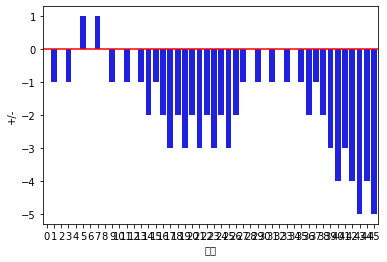

In [64]:
sns.set_palette('Blues')
ax = sns.barplot(x="経過", y='+/-', data=score, color='blue')
ax.axhline(0, color='red')

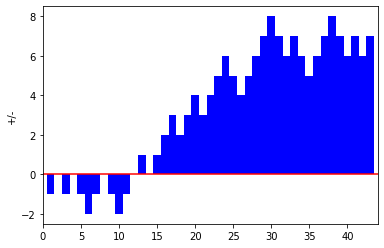

In [13]:
plt.bar(score["経過"], score['+/-'], color='blue', width=1.0)
plt.hlines([0], 0, len(score), 'red')
plt.ylabel('+/-')
plt.xlim(0, len(score))
plt.grid(False)

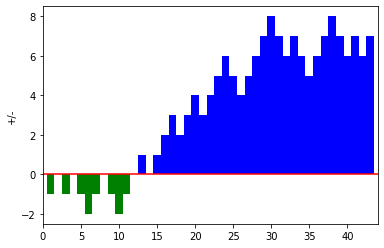

In [22]:
plt.bar(score["経過"], score['+'], color='blue', width=1.0)
plt.bar(score["経過"], score['-'], color='green', width=1.0)
plt.hlines([0], 0, len(score), 'red')
plt.ylabel('+/-')
plt.xlim(0, len(score))
plt.grid(False)

In [49]:
players = list(home_game_log.drop_duplicates(keep='first', subset=["選手"])["選手"].values)
players.remove(np.nan)
players

['曽我', '古賀', '上野', '古谷', '島村', '澤田', 'ネリマン']

In [41]:
home_game_log

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手
0,0,0,0,Tie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0,Tie,NaN,NaN,NaN,NaN,NaN,サーブ,13,梅津,NaN,NaN
2,0,0,0,Tie,レシーブ成功(良),5,曽我,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,0,Tie,NaN,2,古賀,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0,Tie,アタック成功:,6,上野,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,24,19,5,Lead,NaN,NaN,NaN,NaN,NaN,NaN,3,間橋,NaN,NaN
217,24,19,5,Lead,NaN,2,古賀,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218,24,19,5,Lead,NaN,NaN,NaN,NaN,NaN,NaN,3,間橋,NaN,NaN
219,24,19,5,Lead,ブロック成功,1,島村,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
player_log = pd.DataFrame(columns = ["アタック打数", "アタック成功", "アタック失敗", "アタック決定率", "アタック効果率",
                                     "ブロック成功", "サーブ受数", "サーブカット成功(優)", "サーブカット成功(良)", "サーブ打数"])
for player in players:
    player_search = home_game_log[home_game_log["選手"]==player]
    # print(player_search)
    # player_search = home_away_2
    player_attack = player_search[player_search["状況"].str.contains("アタック", na=False)]
    player_attack_a = len(player_attack)
    player_attack_k = len(player_attack[player_attack["状況"]=="アタック成功:"])
    player_attack_e = len(player_attack[player_attack["状況"]=="アタック失敗"])
    # player_attack_a
    if player_attack_a > 0:
        player_attack_pct = round(player_attack_k / player_attack_a, 2)
        player_attack_eff = round((player_attack_k-player_attack_e) / player_attack_a, 2)
#         print(player, player_attack_pct, player_attack_eff)
    else:
        player_attack_pct = None
        player_attack_eff = None
    player_log.loc[player, "アタック打数"] = player_attack_a
    player_log.loc[player, "アタック成功"] = player_attack_k
    player_log.loc[player, "アタック失敗"] = player_attack_e
    player_log.loc[player, "アタック決定率"] = player_attack_pct
    player_log.loc[player, "アタック効果率"] = player_attack_eff
    player_block = len(player_search[player_search["状況"].str.contains("ブロック成功", na=False)])
    player_log.loc[player, "ブロック成功"] = player_block
    player_receive = player_search[player_search["状況"].str.contains("レシーブ", na=False)]
    player_receive_a = len(player_receive)
    player_receive_great = len(player_receive[player_receive["状況"]=="レシーブ成功(優)"])
    player_receive_good = len(player_receive[player_receive["状況"]=="レシーブ成功(良)"])
    player_log.loc[player, "サーブ受数"] = player_receive_a
    player_log.loc[player, "サーブカット成功(優)"] = player_receive_great
    player_log.loc[player, "サーブカット成功(良)"] = player_receive_good
    player_serve = len(player_search[player_search["状況"].str.contains("サーブ", na=False)])
    player_log.loc[player, "サーブ打数"] = player_serve
player_log
# player_search

,アタック打数,アタック成功,アタック失敗,アタック決定率,アタック効果率,ブロック成功,サーブ受数,サーブカット成功(優),サーブカット成功(良),サーブ打数
曽我,6,5,1,0.83,0.67,0,7,1,3,5
古賀,5,2,3,0.4,-0.2,0,11,6,4,3
上野,3,2,1,0.67,0.33,0,0,0,0,3
古谷,8,8,0,1,1,0,0,0,0,1
島村,1,1,0,1,1,1,1,1,0,5
澤田,0,0,0,None,None,1,0,0,0,4
ネリマン,0,0,0,None,None,0,0,0,0,2


In [58]:
livescore_df = []
for livescore in livescore_lists:
    home_game_log = pd.read_csv(livescore)
    home_game_log.loc[home_game_log["状況"] == "サーブ", "サーブ権"] = 'Home'
    home_game_log.loc[home_game_log["相手状況"] == "サーブ", "サーブ権"] = 'Away'
#     home_game_log_2 = home_game_log[1:]
#     print(home_game_log_2)
    livescore_df.append(home_game_log)
home_game_log_2 = pd.concat(livescore_df).reset_index()
len(home_game_log_2)

20097

In [28]:
home_game_log_2[home_game_log_2['状況'].str.contains('ブロ', na=False)]

,index,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権


In [68]:
right_to_serve = ''
player_log = pd.DataFrame(columns = ["アタック打数", "アタック成功", "アタック失敗", "アタック決定率", "アタック効果率",
                                 "ブロック成功", "サーブ受数", "サーブカット成功(優)", "サーブカット成功(良)", "サーブ打数"])
for i in range(len(home_game_log_2)):
    if pd.isnull(home_game_log_2.loc[i,"サーブ権"]):
        home_game_log_2.loc[i,"サーブ権"] = right_to_serve
    else:
        right_to_serve = home_game_log_2.loc[i,"サーブ権"]
#     アタック追加
    if pd.isnull(home_game_log_2.loc[i,"状況"]):
        if pd.isnull(home_game_log_2.loc[i,"選手"]) == False:
            home_game_log_2.loc[i, "状況"] = "アタック"
        else:
            home_game_log_2.loc[i, "状況"] = np.nan
    if pd.isnull(home_game_log_2.loc[i,"相手状況"]):
        if pd.isnull(home_game_log_2.loc[i,"相手選手"]) == False:
            home_game_log_2.loc[i, "相手状況"] = "アタック"
        else:
            home_game_log_2.loc[i, "相手状況"] = np.nan
#         print(right_to_serve) 
#     home_game_log_2.tail()
players = []
players = list(home_game_log_2.drop_duplicates(keep='first', subset=["選手"])["選手"].values)
players.remove(np.nan)
#     print(players)
for player in players:
    player_log.loc[player] = 0
    player_search = home_game_log_2[home_game_log_2["選手"]==player]
    player_attack = player_search[player_search["状況"].str.contains("アタック", na=False)]
    player_attack_a = len(player_attack)
    player_attack_k = len(player_attack[player_attack["状況"]=="アタック成功:"])
    player_attack_e = len(player_attack[player_attack["状況"]=="アタック失敗"])
    # player_attack_a
    player_log.loc[player, "アタック打数"] += player_attack_a
    player_log.loc[player, "アタック成功"] += player_attack_k
    player_log.loc[player, "アタック失敗"] += player_attack_e
    if player_attack_a > 0:
        player_attack_pct = round(player_attack_k * 100 / player_attack_a, 1)
        player_attack_eff = round((player_attack_k-player_attack_e) * 100 / player_attack_a, 1)
#         print(player, player_attack_pct, player_attack_eff)
    else:
        player_attack_pct = None
        player_attack_eff = None
    player_log.loc[player, "アタック決定率"] = player_attack_pct
    player_log.loc[player, "アタック効果率"] = player_attack_eff
    player_block = len(player_search[player_search["状況"].str.contains("ブロック成功", na=False)])
    player_log.loc[player, "ブロック成功"] += player_block
    player_receive = player_search[player_search["状況"].str.contains("レシーブ", na=False)]
    player_receive_a = len(player_receive)
    player_receive_great = len(player_receive[player_receive["状況"]=="レシーブ成功(優)"])
    player_receive_good = len(player_receive[player_receive["状況"]=="レシーブ成功(良)"])
    player_log.loc[player, "サーブ受数"] += player_receive_a
    player_log.loc[player, "サーブカット成功(優)"] += player_receive_great
    player_log.loc[player, "サーブカット成功(良)"] += player_receive_good
#     サーブでは反応しないためサーで検索
    player_serve = len(player_search[player_search["状況"].str.contains("サー", na=False)])
    player_log.loc[player, "サーブ打数"] = player_serve
player_log

,アタック打数,アタック成功,アタック失敗,アタック決定率,アタック効果率,ブロック成功,サーブ受数,サーブカット成功(優),サーブカット成功(良),サーブ打数
小島,0,0,0,None,None,0,368,153,104,0
曽我,404,156,26,38.6,32.2,13,302,102,77,173
山田,211,78,10,37,32.2,39,24,9,6,227
古賀,810,343,36,42.3,37.9,36,526,257,128,336
島村,341,175,10,51.3,48.4,25,28,13,7,179
廣瀬,197,72,11,36.5,31,8,2,1,1,52
澤田,5,2,0,40,40,4,4,0,0,224
塚田,6,3,0,50,50,2,5,0,0,99
山内,272,96,12,35.3,30.9,15,222,95,58,166
柳田,69,21,4,30.4,24.6,1,0,0,0,41


In [ ]:
all_log.tail()

In [56]:
home_game_log.loc[home_game_log["状況"] == "サーブ", "サーブ権"] = 'Home'
home_game_log.loc[home_game_log["相手状況"] == "サーブ", "サーブ権"] = 'Away'
home_game_log_2 = home_game_log[1:]
right_to_serve = ''
for i in range(1, len(home_game_log_2)+1):
    if pd.isnull(home_game_log_2.loc[i,"サーブ権"]):
        home_game_log_2.loc[i,"サーブ権"] = right_to_serve
    else:
        right_to_serve = home_game_log_2.loc[i,"サーブ権"]
#     アタック追加
    if pd.isnull(home_game_log_2.loc[i,"状況"]):
        if pd.isnull(home_game_log_2.loc[i,"選手"]) == False:
            home_game_log_2.loc[i, "状況"] = "アタック"
        else:
            home_game_log_2.loc[i, "状況"] = np.nan
    if pd.isnull(home_game_log_2.loc[i,"相手状況"]):
        if pd.isnull(home_game_log_2.loc[i,"相手選手"]) == False:
            home_game_log_2.loc[i, "相手状況"] = "アタック"
        else:
            home_game_log_2.loc[i, "相手状況"] = np.nan
#         print(right_to_serve)
print(len(home_game_log_2))
home_game_log_2.tail()

175


,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
171,16,15,1,Lead,NaN,NaN,NaN,NaN,NaN,レシーブ失敗,19,野中,NaN,NaN,Home
172,16,15,1,Lead,NaN,NaN,NaN,NaN,NaN,アタック,13,長内,NaN,NaN,Home
173,16,15,1,Lead,アタック,4,柳田,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Home
174,16,15,1,Lead,NaN,NaN,NaN,NaN,NaN,その他ミス,2,小野寺,NaN,NaN,Home
175,17,15,2,Lead,NaN,得点,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Home


In [51]:
away_game_log.loc[away_game_log["状況"] == "サーブ", "サーブ権"] = 'Home'
away_game_log.loc[away_game_log["相手状況"] == "サーブ", "サーブ権"] = 'Away'
away_game_log_2 = away_game_log[1:]
right_to_serve = ''
for i in range(1, len(away_game_log_2)+1):
    if pd.isnull(away_game_log_2.loc[i,"サーブ権"]):
        away_game_log_2.loc[i,"サーブ権"] = right_to_serve
    else:
        right_to_serve = away_game_log_2.loc[i,"サーブ権"]
#     アタック追加
    if pd.isnull(away_game_log_2.loc[i,"状況"]):
        if away_game_log_2.loc[i,"選手"]!=None:
            away_game_log_2.loc[i, "状況"] = "アタック"
        else:
            away_game_log_2.loc[i, "状況"] = np.nan
    if pd.isnull(away_game_log_2.loc[i,"相手状況"]):
        if away_game_log_2.loc[i,"相手選手"]!=None:
            away_game_log_2.loc[i, "相手状況"] = "アタック"
        else:
            away_game_log_2.loc[i, "相手状況"] = np.nan
#         print(right_to_serve) 
away_game_log_2.tail()

NameError: name 'away_game_log' is not defined

In [145]:
lead_home = home_game_log_2[home_game_log_2['+/-'] > 0]
lead_home.tail()

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
243,24,22,2,Lead,NaN,NaN,NaN,NaN,NaN,レシーブ成功(良),11,目黒,NaN,NaN,Home
244,24,22,2,Lead,NaN,NaN,NaN,NaN,NaN,アタック,10,ドルーズ,NaN,NaN,Home
245,24,22,2,Lead,NaN,NaN,NaN,NaN,NaN,アタック,2,林,NaN,NaN,Home
246,24,22,2,Lead,アタック成功:,7,クラン,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Home
247,25,22,3,Lead,NaN,得点,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Home


In [146]:
behind_home = home_game_log_2[home_game_log_2['+/-'] < 0]
behind_home.head()

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
4,0,1,-1,Behind,NaN,NaN,NaN,NaN,NaN,NaN,得点,NaN,NaN,NaN,Away
5,0,1,-1,Behind,NaN,NaN,NaN,NaN,NaN,サーブ,8,籾井,NaN,NaN,Away
6,0,1,-1,Behind,レシーブ失敗,9,黒後,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Away
7,0,1,-1,Behind,アタック成功:,12,石川,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Away
15,1,2,-1,Behind,NaN,NaN,NaN,NaN,NaN,NaN,得点,NaN,NaN,NaN,Home


In [16]:
clutch_log = home_game_log_2[(home_game_log_2["得点"] >= 20) & (home_game_log_2["失点"] >= 20) & (abs(home_game_log_2['+/-']) <= 3)]
clutch_log.tail()

,index,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
17174,198,21,24,-3,Behind,NaN,得点,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17175,199,21,24,-3,Behind,NaN,NaN,NaN,NaN,NaN,NaN,タイムアウト,NaN,NaN,NaN,NaN
17176,200,21,24,-3,Behind,サーブ,10,関,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Home
17177,201,21,24,-3,Behind,NaN,NaN,NaN,NaN,NaN,レシーブ成功(良),2,林,NaN,NaN,NaN
17178,202,21,24,-3,Behind,NaN,NaN,NaN,NaN,NaN,アタック成功:,10,ドルーズ,NaN,NaN,NaN


In [50]:
players = list(home_game_log_2.drop_duplicates(keep='first', subset=["選手"])["選手"].values)
players.remove(np.nan)
players

NameError: name 'home_game_log_2' is not defined

In [63]:
player_log = pd.DataFrame(columns = ["アタック打数", "アタック成功", "アタック失敗", "アタック決定率", "アタック効果率",
                                     "ブロック成功", "サーブ受数", "サーブカット成功(優)", "サーブカット成功(良)", "サーブ打数"])
for player in players:
    player_search = clutch_log[clutch_log["選手"]==player]
    # player_search = home_away_2
    player_attack = player_search[player_search["状況"].str.contains("アタック", na=False)]
    player_attack_a = len(player_attack)
    player_attack_k = len(player_attack[player_attack["状況"]=="アタック成功:"])
    player_attack_e = len(player_attack[player_attack["状況"]=="アタック失敗"])
    # player_attack_a
    if player_attack_a > 0:
        player_attack_pct = round(player_attack_k * 100 / player_attack_a, 1)
        player_attack_eff = round((player_attack_k-player_attack_e) * 100 / player_attack_a, )
#         print(player, player_attack_pct, player_attack_eff)
    else:
        player_attack_pct = None
        player_attack_eff = None
    player_log.loc[player, "アタック打数"] = player_attack_a
    player_log.loc[player, "アタック成功"] = player_attack_k
    player_log.loc[player, "アタック失敗"] = player_attack_e
    player_log.loc[player, "アタック決定率"] = player_attack_pct
    player_log.loc[player, "アタック効果率"] = player_attack_eff
    player_block = len(player_search[player_search["状況"].str.contains("ブロック", na=False)])
    player_log.loc[player, "ブロック成功"] = player_block
    player_receive = player_search[player_search["状況"].str.contains("レシーブ", na=False)]
    player_receive_a = len(player_receive)
    player_receive_great = len(player_receive[player_receive["状況"]=="レシーブ成功(優)"])
    player_receive_good = len(player_receive[player_receive["状況"]=="レシーブ成功(良)"])
    player_log.loc[player, "サーブ受数"] = player_receive_a
    player_log.loc[player, "サーブカット成功(優)"] = player_receive_great
    player_log.loc[player, "サーブカット成功(良)"] = player_receive_good
#     サーブでは反応しないためサーで検索
    player_serve = len(player_search[player_search["状況"].str.contains("サー", na=False)])
    player_log.loc[player, "サーブ打数"] = player_serve
player_log

NameError: name 'clutch_log' is not defined

In [69]:
player_log = pd.DataFrame(columns = ["アタック打数", "アタック成功", "アタック失敗", "アタック決定率", "アタック効果率",
                                     "ブロック成功", "サーブ受数", "サーブカット成功(優)", "サーブカット成功(良)", "サーブ打数"])
for player in players:
    player_search = home_game_log_2[home_game_log_2["選手"]==player]
    # player_search = home_away_2
    player_attack = player_search[player_search["状況"].str.contains("アタック", na=False)]
    player_attack_a = len(player_attack)
    player_attack_k = len(player_attack[player_attack["状況"]=="アタック成功:"])
    player_attack_e = len(player_attack[player_attack["状況"]=="アタック失敗"])
    # player_attack_a
    if player_attack_a > 0:
        player_attack_pct = round(player_attack_k * 100/ player_attack_a, 1)
        player_attack_eff = round((player_attack_k-player_attack_e) * 100/ player_attack_a, 1)
#         print(player, player_attack_pct, player_attack_eff)
    else:
        player_attack_pct = None
        player_attack_eff = None
    player_log.loc[player, "アタック打数"] = player_attack_a
    player_log.loc[player, "アタック成功"] = player_attack_k
    player_log.loc[player, "アタック失敗"] = player_attack_e
    player_log.loc[player, "アタック決定率"] = player_attack_pct
    player_log.loc[player, "アタック効果率"] = player_attack_eff
    player_block = len(player_search[player_search["状況"].str.contains("ブロック成功", na=False)])
    player_log.loc[player, "ブロック成功"] = player_block
    player_receive = player_search[player_search["状況"].str.contains("レシーブ", na=False)]
    player_receive_a = len(player_receive)
    player_receive_great = len(player_receive[player_receive["状況"]=="レシーブ成功(優)"])
    player_receive_good = len(player_receive[player_receive["状況"]=="レシーブ成功(良)"])
    player_log.loc[player, "サーブ受数"] = player_receive_a
    player_log.loc[player, "サーブカット成功(優)"] = player_receive_great
    player_log.loc[player, "サーブカット成功(良)"] = player_receive_good
    player_serve = len(player_search[player_search["状況"].str.contains("サーブ", na=False)])
    player_log.loc[player, "サーブ打数"] = player_serve
player_log

,アタック打数,アタック成功,アタック失敗,アタック決定率,アタック効果率,ブロック成功,サーブ受数,サーブカット成功(優),サーブカット成功(良),サーブ打数
小島,0,0,0,None,None,0,368,153,104,0
曽我,404,156,26,38.6,32.2,13,302,102,77,157
山田,211,78,10,37,32.2,39,24,9,6,205
古賀,810,343,36,42.3,37.9,36,526,257,128,303
島村,341,175,10,51.3,48.4,25,28,13,7,169
廣瀬,197,72,11,36.5,31,8,2,1,1,40
澤田,5,2,0,40,40,4,4,0,0,211
塚田,6,3,0,50,50,2,5,0,0,93
山内,272,96,12,35.3,30.9,15,222,95,58,148
柳田,69,21,4,30.4,24.6,1,0,0,0,36


In [170]:
player_block = player_search[player_search["状況"].str.contains("ブロック")]
player_block

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権


In [179]:
player_receive = len(player_search[player_search["状況"].str.contains("レシーブ")])
player_receive

0

In [160]:
player_log = pd.DataFrame(columns = ["アタック打数", "アタック成功", "アタック失敗", "アタック決定率", "アタック効果率"])
player_log.loc[player, "アタック打数"] = player_attack_a
player_log.loc[player, "アタック成功"] = player_attack_k
player_log.loc[player, "アタック失敗"] = player_attack_e
player_log.loc[player, "アタック決定率"] = player_attack_pct
player_log.loc[player, "アタック効果率"] = player_attack_eff
player_log

,アタック打数,アタック成功,アタック失敗,アタック決定率,アタック効果率
村永,6,0,0,0,0


In [43]:
os.chdir('C:\\Users\\sasno\\Desktop\\MyPandas\\vleague')
division = 'v1_m'
s_round = '2020-21_regular'
# game_set = 1
os.chdir('{}'.format(division))
os.getcwd()
home_game_log.to_csv('{}/{}/{}-livescore-{}set.csv'.format(h_team, s_round, daily, game_set), index=False)
away_game_log.to_csv('{}/{}/{}-livescore-{}set.csv'.format(a_team, s_round, daily, game_set), index=False)

In [52]:
away_game_log

,得点,失点,+/-,L-B,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,状況,番号,選手,交代番号,交代選手
0,0,0,0,Tie,NaN,None,None,None,None,NaN,None,None,None,None
1,0,0,0,Tie,サーブ,8,河東,None,None,NaN,None,None,None,None
2,0,0,0,Tie,NaN,None,None,None,None,レシーブ成功(良),4,高野,None,None
3,0,0,0,Tie,NaN,None,None,None,None,NaN,21,竹元,None,None
4,0,0,0,Tie,NaN,7,戸嵜,None,None,NaN,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,19,24,-5,Behind,NaN,None,None,None,None,サーブミス,12,小池,None,None
205,20,24,-4,Behind,NaN,得点,None,None,None,NaN,None,None,None,None
206,20,24,-4,Behind,NaN,None,None,None,None,メンバー交代:,IN:7,出耒田,OUT:12,小池
207,20,24,-4,Behind,メンバー交代:,IN:21,高澤,OUT:4,中村,NaN,None,None,None,None


In [53]:
away_point = point.reindex(["失点", "得点", '+/-', 'L-B'], axis=1)
away_point['+/-'] = -away_point['+/-']
away_point.loc[away_point['+/-'] > 0, 'L-B'] = 'Lead'
away_point.loc[away_point['+/-'] == 0, 'L-B'] = 'Tie'
away_point.loc[away_point['+/-'] < 0, 'L-B'] = 'Behind'
away_point.columns = ["得点", "失点", '+/-', 'L-B']
away_point

,得点,失点,+/-,L-B
0,0,0,0,Tie
1,0,0,0,Tie
2,0,0,0,Tie
3,0,0,0,Tie
4,0,0,0,Tie
...,...,...,...,...
204,19,24,-5,Behind
205,20,24,-4,Behind
206,20,24,-4,Behind
207,20,24,-4,Behind


In [336]:
away_log.dropna(subset=[3])

,0,1,2,3,4
200,メンバー交代:,IN:21,永露,OUT:11,傳田
205,メンバー交代:,IN:11,傳田,OUT:21,永露


In [337]:
away_log

,0,1,2,3,4
0,NaN,None,None,None,None
1,サーブ,22,高梨,None,None
2,NaN,None,None,None,None
3,NaN,None,None,None,None
4,NaN,None,None,None,None
...,...,...,...,...,...
203,NaN,None,None,None,None
204,NaN,None,None,None,None
205,メンバー交代:,IN:11,傳田,OUT:21,永露
206,NaN,None,None,None,None


In [68]:
point = log_df[[0,1]]
point.columns = ["得点", "失点"]
# point.loc[:,'+/-'] = 0
point.loc[:,'+/-'] = point.loc[:,"得点"] - point.loc[:,"失点"]
point.loc[point['+/-'] > 0, 'L-B'] = 'Lead'
point.loc[point['+/-'] == 0, 'L-B'] = 'Tie'
point.loc[point['+/-'] < 0, 'L-B'] = 'Behind'
point

,得点,失点,+/-,L-B
0,0,0,0,Tie
1,0,0,0,Tie
2,0,0,0,Tie
3,0,0,0,Tie
4,0,0,0,Tie
...,...,...,...,...
204,24,19,5,Lead
205,24,20,4,Lead
206,24,20,4,Lead
207,24,20,4,Lead


In [471]:
home_away = pd.concat([point,home_log, away_log], axis=1)
home_away.tail(10)

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手
198,23,21,2,Lead,NaN,None,None,None,None,NaN,得点,None,None,None
199,23,21,2,Lead,メンバー交代:,IN:10,藤中,OUT:20,西田,NaN,None,None,None,None
200,23,21,2,Lead,NaN,None,None,None,None,メンバー交代:,IN:21,永露,OUT:11,傳田
201,23,21,2,Lead,NaN,None,None,None,None,サーブ,21,永露,None,None
202,23,21,2,Lead,レシーブ成功(良),1,鶴田,None,None,NaN,None,None,None,None
203,23,21,2,Lead,アタック成功:,19,栗山,None,None,NaN,None,None,None,None
204,24,21,3,Lead,NaN,得点,None,None,None,NaN,None,None,None,None
205,24,21,3,Lead,NaN,None,None,None,None,メンバー交代:,IN:11,傳田,OUT:21,永露
206,24,21,3,Lead,サービスエース,3,小野,None,None,NaN,None,None,None,None
207,24,21,3,Lead,NaN,None,None,None,None,レシーブ失敗,22,高梨,None,None


In [485]:
home_away.loc[home_away["状況"] == "サーブ", "サーブ権"] = 'Home'
home_away.loc[home_away["相手状況"] == "サーブ", "サーブ権"] = 'Away'
home_away_2 = home_away[1:]
right_to_serve = ''
for i in range(1, len(home_away_2)+1):
    if pd.isnull(home_away_2.loc[i,"サーブ権"]):
        home_away_2.loc[i,"サーブ権"] = right_to_serve
    else:
        right_to_serve = home_away_2.loc[i,"サーブ権"]
#     アタック追加
    if pd.isnull(home_away_2.loc[i,"状況"]):
        if home_away_2.loc[i,"選手"]!=None:
            home_away_2.loc[i, "状況"] = "アタック"
        else:
            home_away_2.loc[i, "状況"] = ""
    if pd.isnull(home_away_2.loc[i,"相手状況"]):
        if home_away_2.loc[i,"相手選手"]!=None:
            home_away_2.loc[i, "相手状況"] = "アタック"
        else:
            home_away_2.loc[i, "相手状況"] = ""
#         print(right_to_serve) 
home_away_2.head(40)

C:\Users\sasno\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
1,0,0,0,Tie,,None,None,None,None,サーブ,22,高梨,None,None,Away
2,0,0,0,Tie,レシーブ成功(優),10,藤中,None,None,,None,None,None,None,Away
3,0,0,0,Tie,アタック成功:,19,栗山,None,None,,None,None,None,None,Away
4,1,0,1,Lead,,得点,None,None,None,,None,None,None,None,Away
5,1,0,1,Lead,サーブ,8,柳田,None,None,,None,None,None,None,Home
6,1,0,1,Lead,,None,None,None,None,レシーブ失敗,24,小川,None,None,Home
7,1,0,1,Lead,アタック成功:,19,栗山,None,None,,None,None,None,None,Home
8,2,0,2,Lead,,得点,None,None,None,,None,None,None,None,Home
9,2,0,2,Lead,サーブ,8,柳田,None,None,,None,None,None,None,Home
10,2,0,2,Lead,,None,None,None,None,レシーブ成功(良),1,山田,None,None,Home


In [449]:
home_away_2.sort_values(["選手", "状況"])

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
172,20,18,2,Lead,サービスエース,15,喜入,None,None,NaN,None,None,None,None,Away
175,21,18,3,Lead,サーブ,15,喜入,None,None,NaN,None,None,None,None,Home
171,20,18,2,Lead,メンバー交代:,IN:15,喜入,OUT:12,塩田,NaN,None,None,None,None,Away
53,7,5,2,Lead,アタック成功:,12,塩田,None,None,NaN,None,None,None,None,Away
18,3,1,2,Lead,サーブ,12,塩田,None,None,NaN,None,None,None,None,Home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,23,21,2,Lead,NaN,None,None,None,None,メンバー交代:,IN:21,永露,OUT:11,傳田,Home
201,23,21,2,Lead,NaN,None,None,None,None,サーブ,21,永露,None,None,Away
204,24,21,3,Lead,NaN,得点,None,None,None,NaN,None,None,None,None,Away
205,24,21,3,Lead,NaN,None,None,None,None,メンバー交代:,IN:11,傳田,OUT:21,永露,Away


In [489]:
player_search = home_away_2[home_away_2["相手選手"]=="クレク"]
# player_search = home_away_2
player_attack = player_search[player_search["相手状況"].str.contains("アタック")]
player_attack

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
28,4,2,2,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Home
38,5,3,2,Lead,,None,None,None,None,アタック,3,クレク,None,None,Home
77,11,7,4,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Home
101,14,9,5,Lead,,None,None,None,None,アタック,3,クレク,None,None,Home
120,16,11,5,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Home
137,16,14,2,Lead,,None,None,None,None,アタック,3,クレク,None,None,Away
147,17,15,2,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Away
159,19,16,3,Lead,,None,None,None,None,アタック,3,クレク,None,None,Home
162,19,16,3,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Home
166,19,17,2,Lead,,None,None,None,None,アタック,3,クレク,None,None,Away


In [490]:
player_sideout = player_attack[player_attack["サーブ権"]=='Away']
player_sideout

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
137,16,14,2,Lead,,None,None,None,None,アタック,3,クレク,None,None,Away
147,17,15,2,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Away
166,19,17,2,Lead,,None,None,None,None,アタック,3,クレク,None,None,Away
167,19,17,2,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Away


In [491]:
player_break = player_attack[player_attack["サーブ権"]=='Home']
player_break

,得点,失点,+/-,L-B,状況,番号,選手,交代番号,交代選手,相手状況,相手番号,相手選手,相手交代番号,相手交代選手,サーブ権
28,4,2,2,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Home
38,5,3,2,Lead,,None,None,None,None,アタック,3,クレク,None,None,Home
77,11,7,4,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Home
101,14,9,5,Lead,,None,None,None,None,アタック,3,クレク,None,None,Home
120,16,11,5,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Home
159,19,16,3,Lead,,None,None,None,None,アタック,3,クレク,None,None,Home
162,19,16,3,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Home
177,21,18,3,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Home
189,22,19,3,Lead,,None,None,None,None,アタック成功:,3,クレク,None,None,Home


In [346]:
os.chdir('/Users/sasno/Desktop/MyPandas/vleague')
# os.chdir(division)
print(os.getcwd())

C:\Users\sasno\Desktop\MyPandas\vleague
